In [5]:
!pip install rasterio
!pip install fiona
!pip install shapely
!pip install geopandas
!pip install pycrs


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib import ticker
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import re #used for making multiple string splits
import json
import os

from matplotlib.colors import ListedColormap
import numpy as np

In [3]:
#load input file
# fp = r'cgls_landcover_2015_classification.tiff'
fp = r'cci_landcovers/cci_landcover_2015.tif'
# fp = "dataPreprocessing/precipitationData/my_test_data.tif"
# fp = "dataPreprocessing/temperatureData/tiffTemperatureData/LST2012_avg.tiff"
data = rasterio.open(fp)



In [13]:
def show_land_cover(file):
    #labels for plotting
    labels = {0: {'color': '#282828', 'flag': 'unknown'},
              20: {'color': '#FFBB22', 'flag': 'shrubs'},
              30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
              40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
              50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
              60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
              70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
              80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
              90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
              100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
              111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
              112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
              113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
              114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
              115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
              116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
              121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
              122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
              123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
              124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
              125: {'color': '#929900', 'flag': 'open_forest_mixed'},
              126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
              200: {'color': '#000080', 'flag': 'oceans_seas'}}
    #colors1 = [label['color'] for label in labels.values()]
    cmap = ListedColormap([label['color'] for label in labels.values()]).reversed()
    norm = colors.BoundaryNorm(list(labels.keys())+[201], cmap.N+1, extend='max')
    ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))
    cblabels=[label['flag'] for label in labels.values()]
    
    # #file setup
    # img_name, _ = img.split("_")
    # img_name = img_name + ".tiff"
    # # print(img_name)
    
    data = None
    with rasterio.open(file) as src:
        data = src.read()
        src.close() # close the rasterio dataset
    
#     data_array = np.array(data)
#     print(np.amin(data_array), np.amax(data_array))
# #     print(np.around(data_array, 1))
#     data_array = data_array[0,:,:]
#     arr = data_array
# #     arr = data_array * 0.02 - 273.15 #convert to celcius
#     print(np.around(arr, 1))
#     plt.imshow(arr)
#     plt.show()
        
#     src = rasterio.open("landcover/"+img_name)
#     data = src.read()
    
    fig, ax = plt.subplots()

    cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=200.5), cmap=cmap), ax=ax)
    tick_locator = ticker.FixedLocator(locs=[(i*(200/23)+5) for i in range(len(ticks))])
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_ticklabels(cblabels[::-1])

    show(data, ax=ax, cmap=cmap, norm=norm) #transform=src.transform
    
    src.close()

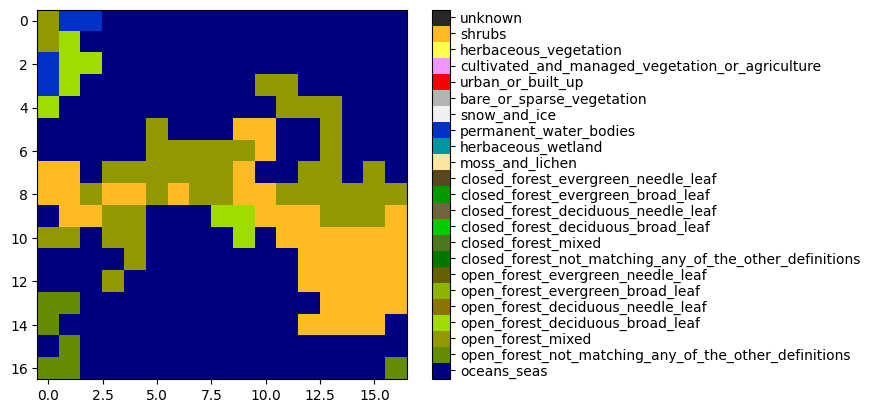

In [14]:
file = "landcover_1992onwards_min5examined/3.tiff"
show_land_cover(file)


In [6]:
#inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def generate_land_cover_image(satellite_image_name, input_file, view=0.01):
    out_name, coordinates = satellite_image_name.split("_")
    out_name = out_name + ".tiff"
    lat, lon = re.split(", |.png|,", coordinates)[:2]
    lat = float(lat)
    lon = float(lon)
    
    #finding the bounding box of the center coordinate
    up_rightX, up_rightY = round(lat-view,4), round(lon+view,4)
    down_leftX, down_leftY = round(lat+view,4), round(lon-view,4)
    bbox = box(up_rightX,up_rightY,down_leftX,down_leftY)
    # print("bbox", bbox)
    
    #Insert the BB to a GeoDataFrame and reproject it into the coordinate system of the input image
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=data.crs.data)
    
    #Now we can receive the coordinates in the format that rasterio needs. 
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    #Clips the data with the defined polygon
    out_img, out_transform = mask(input_file, shapes=coords, all_touched=True, crop=True)
    
    #Updating the metadata
    out_meta = data.meta.copy()
    # print(out_meta)
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                   })
    
    #Writing the clipped image
    filepath = "./landcover/"+out_name
    if os.path.exists(filepath):
        os.remove(filepath) # delete the file 
    with rasterio.open(filepath, "w", **out_meta) as dest:
        dest.write(out_img)
        dest.close() # close the rasterio dataset
        

Manual testing

In [8]:
file = "1_27.3348, -16.9727.png"
# file = "2_27.3684, -17.479.png" 
# file = "100_27.2562, -16.7782.png"
# file = "200_8.8124, 3.7315.png"  #Very good test by manual inspection, clearly on Malabo
# file = "210_31.379, 1.8387.png" # An ok test by manual inspection, we can see it is a bit northwest of lake victoria.


# print(np.amin(data), np.amax(data))


# generate_land_cover_image(satellite_image_name=file, input_file = data, view=2000) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.5) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.1) #6_28.7472, -16.504.png
# show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.023) #6_28.7472, -16.504.png
show_land_cover(file)

C:\Users\r-kli\AppData\Local\Temp\ipykernel_10872\1083690930.py:25: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.023) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


RasterioIOError: Attempt to create new tiff file './landcover/1.tiff' failed: No such file or directory

In [7]:
import csv
import os

# long_lat_year_path = "dataPreprocessing/malariaData/long_lat_year_with_confidential_from2010to18_size10orGreater.csv"
long_lat_year_path = "dataPreprocessing/malariaData/long_lat_year_country_1992onwards_min5examined.csv"

dataset_list = os.listdir('dataset')
fp_first = r'cci_landcovers/cci_landcover_'
# fp_first = r'dataPreprocessing/temperatureData/tiffTemperatureData/LST'
# fp_first = r'dataPreprocessing/precipitationData/tiffRainData/'

fp_last = '.tif'
# fp_last = '_avg.tiff'
# fp_last = 'rain_africa.tiff'

# Go through long_lat_year file instead of directory with images
with open(long_lat_year_path, encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        # print(row)
        id = row[0]
        print(id)
        if int(id) < 12190:
            continue
        long = row[1]
        lat = row[2]
        year = row[3]
        image_name = id+'_'+long + ", " + lat + ".png"
        fp = fp_first + year + fp_last
        data = rasterio.open(fp)
        generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)


# dataset_list = os.listdir('dataset')
# for image in dataset_list:
#     if image == '.DS_Store':
#         continue
#     generate_land_cover_image(satellite_image_name=image, input_file = data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12225
12226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12268
12269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12272
12273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12274
12275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12277
12278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12279
12280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12281
12282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12283
12284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12285
12286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12290
12291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12294
12295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12299
12300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12304
12305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12310
12311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12313
12314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12344
12345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12346
12347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12348
12349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12350
12351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12352
12353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12354
12355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12356
12357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12358
12359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12360
12361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12362
12363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12391
12392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12395
12396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12400
12401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12402
12403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12404
12405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12406
12407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12408
12409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12410
12411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12412
12413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12414
12415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12416
12417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12418
12419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12423
12424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12440
12441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12442
12443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12444
12445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12452
12453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12454
12455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12456
12457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12458
12459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12460
12461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12462
12463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12464
12465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12466
12467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12493
12494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12510
12511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12585
12586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12587
12588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12589
12590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12591
12592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12593
12594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12601
12602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12603
12604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12605
12606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12610
12611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12612
12613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12614
12615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12616
12617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12618
12619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12620
12621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12622
12623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12624
12625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12626
12627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12628
12629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12630
12631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12632
12633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12635
12636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12637
12638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12670
12671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12685
12686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12708
12709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12710
12711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12712
12713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12714
12715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12716
12717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12733
12734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12763
12764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12768
12769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12770
12771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12772
12773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12774
12775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12776
12777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12778
12779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12780
12781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12785
12786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12787
12788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12789
12790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12791
12792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12793
12794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12802
12803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12804
12805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12806
12807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12808
12809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12810
12811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12812
12813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12814
12815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12816
12817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12818
12819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12820
12821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12822
12823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12824
12825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12826
12827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12828
12829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12830
12831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12832
12833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12840
12841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12870
12871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12873
12874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12875
12876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12877
12878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12879
12880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12881
12882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12883
12884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12885
12886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12887
12888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12889
12890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12891
12892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12893
12894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12895
12896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12897
12898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12899
12900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12902
12903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12927
12928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12929
12930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12931
12932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12933
12934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12935
12936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12938
12939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12941
12942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12944
12945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12946
12947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12948
12949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12950
12951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12952
12953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

12954
12955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


12999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13033
13034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13036
13037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13040
13041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13051
13052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13075
13076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13086
13087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13096
13097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13104
13105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13130
13131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13134
13135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13180
13181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13182
13183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13189
13190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13191
13192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13193
13194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13195
13196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13197
13198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13205
13206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13233
13234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13271
13272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13325
13326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13341
13342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13424
13425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13426
13427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13431
13432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13433
13434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13435
13436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13437
13438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13440
13441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13442
13443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13446
13447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13448
13449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13451
13452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13453
13454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13455
13456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13457
13458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13470
13471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13478
13479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13480
13481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13499
13500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13514
13515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13516
13517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13522
13523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13556
13557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13565
13566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13583
13584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13590
13591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13593
13594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13595
13596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13597
13598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13599
13600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13601
13602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13620
13621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13630
13631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13632
13633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13634
13635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13636
13637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13638
13639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13665
13666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13668
13669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13671
13672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13687
13688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13694
13695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13698
13699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13751
13752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13757
13758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13781
13782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13783
13784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13785
13786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13787
13788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13789
13790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13810
13811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13816
13817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13818
13819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13820
13821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13822
13823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13824
13825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13826
13827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13828
13829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13830
13831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13832
13833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13834
13835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13836
13837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13838
13839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13840
13841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13842
13843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13844
13845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13846
13847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13881
13882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13896
13897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13903
13904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13909
13910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13919
13920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13922
13923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13924
13925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13926
13927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13928
13929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13930
13931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13932
13933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13934
13935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13936
13937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13938
13939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13940
13941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13942
13943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13944
13945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13946
13947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13948
13949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13950
13951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13952
13953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13954
13955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13958
13959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13982
13983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

13984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


13999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14003
14004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14006
14007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14008
14009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14010
14011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14012
14013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14014
14015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14016
14017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14018
14019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14020
14021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14022
14023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14024
14025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14026
14027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14028
14029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14030
14031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14032
14033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14034
14035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14036
14037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14040
14041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14046
14047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14050
14051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14052
14053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14059
14060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14080
14081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14084
14085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14105
14106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14107
14108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14109
14110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14111
14112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14113
14114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14115
14116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14117
14118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14119
14120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14121
14122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14124
14125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14127
14128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14136
14137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14190
14191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14285
14286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14334
14335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14364
14365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14366
14367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14368
14369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14401
14402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14403
14404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14405
14406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14407
14408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14409
14410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14411
14412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14413
14414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14415
14416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14417
14418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14419
14420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14421
14422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14423
14424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14425
14426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14427
14428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14429
14430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14431
14432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14440
14441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14555
14556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14557
14558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14570
14571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14581
14582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14585
14586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14587
14588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14693
14694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14705
14706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14756
14757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14761
14762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14768
14769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14770
14771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14772
14773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14774
14775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14777
14778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14779
14780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14781
14782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14783
14784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14785
14786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14787
14788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14789
14790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14793
14794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14810
14811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14812
14813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14814
14815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14817
14818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14820
14821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14822
14823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14825
14826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14827
14828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14832
14833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14834
14835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14843
14844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14845
14846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14847
14848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14849
14850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14851
14852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14853
14854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14855
14856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14857
14858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14859
14860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14861
14862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14876
14877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14884
14885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14886
14887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14888
14889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14891
14892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14893
14894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14901
14902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14903
14904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14905
14906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14907
14908
14909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14910
14911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14912
14913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14914
14915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14916
14917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14918
14919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14920
14921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14922
14923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14928
14929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14930
14931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14932
14933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14934
14935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14936
14937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14938
14939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14940
14941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14942
14943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14944
14945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14946
14947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14948
14949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14957
14958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14960
14961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14978
14979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14982
14983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14984
14985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14986
14987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14988
14989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14990
14991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14992
14993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14994
14995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14996
14997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

14998
14999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15000
15001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15002
15003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15007
15008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15010
15011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15012
15013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15016
15017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15018
15019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15020
15021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15022
15023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15024
15025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15026
15027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15028
15029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15034
15035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15086
15087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15088
15089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15090
15091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15092
15093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15094
15095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15103
15104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15105
15106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15107
15108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15109
15110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15111
15112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15125
15126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15127
15128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15129
15130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15131
15132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15133
15134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15135
15136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15143
15144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15145
15146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15147
15148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15149
15150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15151
15152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15153
15154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15159
15160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15168
15169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15170
15171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15172
15173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15174
15175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15184
15185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15186
15187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15188
15189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15190
15191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15192
15193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15194
15195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15196
15197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15198
15199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15201
15202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15203
15204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15205
15206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15207
15208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15209
15210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15211
15212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15213
15214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15215
15216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15218
15219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15220
15221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15222
15223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15224
15225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15226
15227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15228
15229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15230
15231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15238
15239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15240
15241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15242
15243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15244
15245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15246
15247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15248
15249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15259
15260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15262
15263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15264
15265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15266
15267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15268
15269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15270
15271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15278
15279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15280
15281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15282
15283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15284
15285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15286
15287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15293
15294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15295
15296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15297
15298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15299
15300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15301
15302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15308
15309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15310
15311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15312
15313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15314
15315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15316
15317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15318
15319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15320
15321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15327
15328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15329
15330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15331
15332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15333
15334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15335
15336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15337
15338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15339
15340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15341
15342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15343
15344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15345
15346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15347
15348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15349
15350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15351
15352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15353
15354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15355
15356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15458
15459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15460
15461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15462
15463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15464
15465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15466
15467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15468
15469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15470
15471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15472
15473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15474
15475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15476
15477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15478
15479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15487
15488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15516
15517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15548
15549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15556
15557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15560
15561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15562
15563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15564
15565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15566
15567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15568
15569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15570
15571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15577
15578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15579
15580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15581
15582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15583
15584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15585
15586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15592
15593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15594
15595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15596
15597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15601
15602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15603
15604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15605
15606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15607
15608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15609
15610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15611
15612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15615
15616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15617
15618
15619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15620
15621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15622
15623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15624
15625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15626
15627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15637
15638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15639
15640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15641
15642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15643
15644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15649
15650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15651
15652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15653
15654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15655
15656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15657
15658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15660
15661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15662
15663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15664
15665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15669
15670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15671
15672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15673
15674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15675
15676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15677
15678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15679
15680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15684
15685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15686
15687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15688
15689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15690
15691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15692
15693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15694
15695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15699
15700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15701
15702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15703
15704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15705
15706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15707
15708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15709
15710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15713
15714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15718
15719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15720
15721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15722
15723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15724
15725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15726
15727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15730
15731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15732
15733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15734
15735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15736
15737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15738
15739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15740
15741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15745
15746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15747
15748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15749
15750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15751
15752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15753
15754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15756
15757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15758
15759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15760
15761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15762
15763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15764
15765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15766
15767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15772
15773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15774
15775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15776
15777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15778
15779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15780
15781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15787
15788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15789
15790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15791
15792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15793
15794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15795
15796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15800
15801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15802
15803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15804
15805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15806
15807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15808
15809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15810
15811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15813
15814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15818
15819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15820
15821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15822
15823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15825
15826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15827
15828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15829
15830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15831
15832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15833
15834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15835
15836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15844
15845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15846
15847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15848
15849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15850
15851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15853
15854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15855
15856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15857
15858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15859
15860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15861
15862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15863
15864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15867
15868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15869
15870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15872
15873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15874
15875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15876
15877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15878
15879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15884
15885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15886
15887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15888
15889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15890
15891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15892
15893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15894
15895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15899
15900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15901
15902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15903
15904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15905
15906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15907
15908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15913
15914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15915
15916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15917
15918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15919
15920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15921
15922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15923
15924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15927
15928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15929
15930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15931
15932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15933
15934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15935
15936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15937
15938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15942
15943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15944
15945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15946
15947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15948
15949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15950
15951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15952
15953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15957
15958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15959
15960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15961
15962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15963
15964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15967
15968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15969
15970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15971
15972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15973
15974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15975
15976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15977
15978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15979
15980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15981
15982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15986
15987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15990
15991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


15995
15996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15997
15998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

15999
16000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16001
16002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16003
16004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16005
16006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16007
16008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16015
16016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16018
16019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16020
16021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16022
16023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16025
16026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16027
16028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16029
16030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16031
16032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16033
16034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16035
16036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16037
16038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16039
16040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16041
16042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16048
16049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16050
16051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16053
16054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16055
16056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16057
16058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16064
16065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16069
16070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16071
16072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16073
16074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16075
16076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16077
16078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16082
16083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16084
16085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16086
16087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16088
16089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16090
16091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16092
16093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16098
16099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16100
16101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16102
16103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16104
16105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16106
16107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16108
16109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16111
16112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16113
16114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16115
16116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16117
16118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16119
16120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16121
16122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16123
16124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16125
16126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16127
16128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16129
16130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16131
16132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16133
16134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16135
16136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16139
16140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16141
16142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16143
16144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16145
16146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16147
16148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16156
16157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16158
16159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16160
16161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16162
16163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16165
16166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16167
16168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16169
16170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16171
16172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16173
16174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16176
16177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16180
16181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16182
16183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16184
16185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16186
16187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16191
16192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16193
16194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16195
16196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16197
16198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16199
16200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16201
16202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16209
16210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16211
16212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16213
16214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16215
16216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16217
16218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16221
16222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16223
16224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16225
16226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16227
16228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16229
16230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16233
16234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16235
16236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16237
16238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16239
16240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16241
16242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16243
16244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16248
16249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16250
16251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16252
16253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16257
16258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16259
16260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16261
16262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16263
16264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16265
16266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16267
16268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16269
16270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16272
16273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16274
16275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16276
16277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16278
16279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16280
16281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16282
16283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16284
16285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16289
16290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16291
16292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16293
16294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16295
16296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16297
16298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16299
16300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16301
16302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16304
16305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16306
16307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16308
16309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16310
16311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16312
16313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16314
16315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16318
16319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16320
16321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16322
16323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16324
16325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16326
16327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16328
16329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16330
16331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16332
16333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16336
16337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16338
16339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16340
16341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16342
16343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16344
16345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16346
16347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16348
16349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16353
16354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16355
16356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16357
16358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16359
16360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16363
16364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16365
16366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16367
16368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16369
16370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16371
16372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16373
16374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16375
16376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16383
16384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16385
16386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16387
16388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16389
16390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16392
16393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16394
16395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16396
16397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16398
16399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16400
16401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16402
16403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16411
16412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16413
16414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16415
16416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16417
16418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16419
16420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16426
16427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16428
16429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16430
16431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16432
16433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16434
16435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16437
16438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16439
16440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16441
16442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16445
16446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16447
16448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16449
16450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16451
16452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16453
16454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16455
16456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16459
16460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16461
16462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16463
16464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16465
16466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16467
16468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16469
16470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16478
16479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16482
16483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16484
16485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16486
16487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16492
16493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16494
16495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16496
16497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16498
16499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16500
16501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16502
16503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16508
16509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16510
16511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16512
16513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16514
16515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16516
16517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16518
16519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16522
16523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16524
16525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16526
16527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16528
16529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16530
16531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16532
16533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16537
16538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16539
16540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16541
16542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16543
16544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16545
16546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16550
16551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16552
16553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16554
16555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16559
16560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16561
16562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16563
16564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16567
16568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16569
16570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16574
16575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16576
16577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16578
16579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16580
16581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16582
16583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16584
16585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16589
16590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16591
16592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16593
16594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16595
16596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16598
16599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16600
16601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16602
16603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16604
16605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16606
16607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16608
16609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16610
16611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16620
16621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16622
16623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16624
16625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16626
16627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16628
16629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16630
16631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16634
16635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16636
16637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16638
16639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16640
16641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16642
16643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16644
16645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16650
16651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16652
16653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16654
16655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16658
16659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16660
16661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16662
16663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16668
16669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16670
16671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16672
16673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16674
16675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16676
16677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16685
16686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16687
16688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16689
16690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16691
16692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16693
16694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16698
16699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16700
16701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16702
16703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16704
16705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16706
16707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16708
16709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16712
16713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16714
16715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16716
16717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16718
16719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16720
16721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16722
16723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16724
16725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16726
16727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16728
16729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16733
16734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16735
16736
16737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16738
16739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16740
16741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16742
16743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16748
16749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16750
16751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16752
16753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16754
16755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16756
16757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16761
16762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16763
16764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16765
16766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16767
16768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16769
16770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16771
16772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16774
16775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16782
16783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16784
16785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16786
16787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16788
16789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16790
16791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16792
16793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16794
16795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16801
16802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16803
16804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16805
16806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16807
16808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16812
16813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16814
16815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16816
16817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16818
16819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16820
16821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16822
16823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16827
16828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16829
16830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16831
16832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16833
16834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16835
16836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16837
16838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16843
16844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16845
16846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16847
16848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16849
16850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16851
16852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16853
16854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16858
16859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16860
16861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16862
16863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16867
16868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16869
16870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16871
16872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16873
16874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16875
16876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16882
16883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16884
16885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16886
16887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16888
16889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16890
16891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16892
16893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16894
16895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16899
16900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16901
16902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16903
16904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16905
16906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16907
16908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16909
16910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16914
16915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16916
16917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16918
16919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16920
16921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16922
16923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16929
16930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16931
16932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16933
16934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16935
16936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16937
16938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16946
16947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16948
16949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16950
16951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16952
16953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16954
16955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16956
16957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16959
16960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16964
16965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16966
16967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16969
16970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16971
16972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16973
16974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16975
16976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16977
16978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16983
16984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16985
16986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16987
16988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16989
16990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16991
16992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16993
16994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

16995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


16998
16999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17000
17001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17002
17003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17004
17005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17006
17007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17008
17009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17015
17016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17017
17018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17019
17020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17021
17022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17023
17024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17032
17033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17034
17035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17036
17037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17038
17039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17040
17041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17042
17043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17044
17045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17046
17047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17054
17055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17056
17057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17058
17059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17060
17061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17062
17063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17081
17082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17083
17084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17086
17087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17088
17089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17090
17091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17108
17109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17110
17111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17112
17113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17114
17115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17116
17117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17122
17123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17124
17125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17130
17131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17132
17133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17134
17135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17136
17137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17138
17139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17143
17144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17145
17146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17147
17148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17149
17150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17151
17152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17153
17154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17155
17156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17159
17160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17161
17162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17163
17164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17167
17168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17169
17170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17171
17172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17177
17178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17179
17180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17181
17182
17183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17184
17185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17186
17187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17191
17192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17193
17194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17195
17196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17197
17198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17199
17200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17205
17206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17207
17208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17209
17210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17211
17212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17213
17214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17215
17216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17218
17219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17220
17221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17222
17223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17224
17225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17227
17228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17229
17230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17232
17233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17236
17237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17238
17239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17240
17241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17242
17243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17248
17249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17250
17251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17252
17253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17254
17255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17256
17257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17258
17259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17262
17263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17264
17265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17266
17267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17272
17273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17274
17275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17276
17277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17278
17279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17280
17281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17282
17283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17287
17288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17289
17290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17291
17292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17293
17294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17295
17296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17300
17301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17302
17303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17304
17305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17309
17310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17311
17312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17313
17314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17317
17318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17319
17320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17321
17322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17323
17324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17325
17326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17331
17332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17333
17334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17335
17336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17340
17341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17342
17343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17348
17349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17350
17351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17352
17353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17354
17355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17356
17357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17358
17359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17361
17362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17363
17364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17365
17366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17367
17368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17372
17373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17374
17375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17376
17377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17381
17382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17383
17384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17385
17386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17387
17388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17389
17390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17391
17392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17398
17399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17400
17401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17402
17403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17404
17405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17413
17414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17415
17416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17417
17418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17419
17420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17421
17422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17429
17430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17431
17432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17433
17434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17438
17439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17440
17441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17442
17443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17444
17445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17446
17447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17448
17449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17450
17451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17452
17453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17457
17458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17459
17460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17464
17465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17466
17467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17468
17469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17470
17471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17472
17473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17474
17475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17478
17479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17480
17481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17482
17483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17485
17486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17488
17489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17490
17491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17492
17493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17494
17495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17496
17497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17498
17499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17503
17504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17505
17506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17507
17508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17512
17513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17514
17515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17516
17517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17518
17519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17520
17521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17522
17523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17527
17528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17529
17530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17531
17532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17533
17534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17535
17536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17537
17538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17542
17543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17544
17545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17546
17547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17551
17552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17553
17554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17555
17556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17557
17558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17559
17560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17564
17565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17566
17567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17568
17569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17570
17571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17572
17573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17574
17575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17576
17577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17578
17579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17580
17581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17583
17584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17586
17587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17588
17589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17590
17591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17592
17593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17594
17595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17596
17597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17598
17599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17600
17601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17607
17608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17609
17610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17611
17612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17613
17614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17615
17616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17617
17618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17624
17625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17626
17627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17628
17629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17630
17631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17632
17633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17634
17635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17636
17637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17638
17639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17640
17641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17642
17643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17649
17650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17651
17652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17655
17656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17657
17658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17659
17660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17661
17662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17663
17664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17665
17666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17670
17671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17672
17673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17674
17675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17680
17681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17682
17683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17684
17685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17686
17687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17689
17690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17691
17692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17693
17694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17701
17702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17703
17704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17705
17706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17710
17711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17712
17713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17714
17715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17716
17717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17718
17719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17720
17721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17725
17726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17727
17728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17729
17730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17731
17732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17733
17734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17735
17736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17737
17738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17745
17746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17747
17748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17749
17750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17751
17752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17753
17754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17762
17763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17764
17765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17767
17768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17772
17773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17775
17776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17777
17778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17783
17784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17785
17786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17787
17788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17789
17790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17791
17792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17793
17794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17800
17801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17802
17803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17804
17805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17806
17807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17808
17809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17810
17811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17812
17813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17816
17817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17818
17819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17820
17821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17823
17824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17831
17832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17833
17834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17835
17836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17837
17838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17842
17843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17844
17845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17846
17847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17848
17849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17850
17851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17852
17853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17856
17857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17858
17859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17860
17861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17862
17863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17864
17865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17866
17867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17874
17875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17876
17877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17878
17879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17881
17882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17883
17884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17885
17886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17887
17888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17889
17890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17891
17892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17893
17894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17895
17896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17898
17899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17907
17908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17909
17910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17912
17913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17914
17915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17916
17917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17918
17919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17920
17921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17922
17923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17929
17930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17932
17933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17934
17935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17936
17937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17943
17944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17945
17946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17947
17948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17949
17950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17955
17956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17957
17958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17959
17960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17961
17962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17963
17964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17965
17966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17967
17968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17969
17970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17974
17975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17976
17977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17978
17979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17980
17981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17982
17983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17984
17985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


17989
17990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17991
17992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17993
17994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17995
17996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17997
17998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

17999
18000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18001
18002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18011
18012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18013
18014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18015
18016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18017
18018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18019
18020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18021
18022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18025
18026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18027
18028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18029
18030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18031
18032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18033
18034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18035
18036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18039
18040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18044
18045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18046
18047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18048
18049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18050
18051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18052
18053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18061
18062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18063
18064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18065
18066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18067
18068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18069
18070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18071
18072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18073
18074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18075
18076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18077
18078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18079
18080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18081
18082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18083
18084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18086
18087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18091
18092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18093
18094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18095
18096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18097
18098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18099
18100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18101
18102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18103
18104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18106
18107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18108
18109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18110
18111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18112
18113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18117
18118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18119
18120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18121
18122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18123
18124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18125
18126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18127
18128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18134
18135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18136
18137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18138
18139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18140
18141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18144
18145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18146
18147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18148
18149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18150
18151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18152
18153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18154
18155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18156
18157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18158
18159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18160
18161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18165
18166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18168
18169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18170
18171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18172
18173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18174
18175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18176
18177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18183
18184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18185
18186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18187
18188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18191
18192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18193
18194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18195
18196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18197
18198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18199
18200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18201
18202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18209
18210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18211
18212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18215
18216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18217
18218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18219
18220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18221
18222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18223
18224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18227
18228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18229
18230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18231
18232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18233
18234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18235
18236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18237
18238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18241
18242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18243
18244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18245
18246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18247
18248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18252
18253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18254
18255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18256
18257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18258
18259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18260
18261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18262
18263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18274
18275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18276
18277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18278
18279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18280
18281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18282
18283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18284
18285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18289
18290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18291
18292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18293
18294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18295
18296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18297
18298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18299
18300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18301
18302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18305
18306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18307
18308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18309
18310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18311
18312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18313
18314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18315
18316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18317
18318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18319
18320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18321
18322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18323
18324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18325
18326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18327
18328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18331
18332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18333
18334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18335
18336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18337
18338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18339
18340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18341
18342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18343
18344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18345
18346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18347
18348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18349
18350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18351
18352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18353
18354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18355
18356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18357
18358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18365
18366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18367
18368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18369
18370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18373
18374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18376
18377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18378
18379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18380
18381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18382
18383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18384
18385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18389
18390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18391
18392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18393
18394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18395
18396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18397
18398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18399
18400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18404
18405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18406
18407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18408
18409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18411
18412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18413
18414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18415
18416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18417
18418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18419
18420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18421
18422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18423
18424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18427
18428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18429
18430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18431
18432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18433
18434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18435
18436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18437
18438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18439
18440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18449
18450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18451
18452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18453
18454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18455
18456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18457
18458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18459
18460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18461
18462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18465
18466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18467
18468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18469
18470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18471
18472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18475
18476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18477
18478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18479
18480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18481
18482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18483
18484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18485
18486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18489
18490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18491
18492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18493
18494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18495
18496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18500
18501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18502
18503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18504
18505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18506
18507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18508
18509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18510
18511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18512
18513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18520
18521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18523
18524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18528
18529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18530
18531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18532
18533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18534
18535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18536
18537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18538
18539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18546
18547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18550
18551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18552
18553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18554
18555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18556
18557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18558
18559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18560
18561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18562
18563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18565
18566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18567
18568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18571
18572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18573
18574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18575
18576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18577
18578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18579
18580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18583
18584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18585
18586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18587
18588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18589
18590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18592
18593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18594
18595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18596
18597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18598
18599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18600
18601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18602
18603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18604
18605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18608
18609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18610
18611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18612
18613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18614
18615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18616
18617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18618
18619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18625
18626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18630
18631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18632
18633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18634
18635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18638
18639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18640
18641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18642
18643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18644
18645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18649
18650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18651
18652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18653
18654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18655
18656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18657
18658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18659
18660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18663
18664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18665
18666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18667
18668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18669
18670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18672
18673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18674
18675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18676
18677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18678
18679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18680
18681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18682
18683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18684
18685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18688
18689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18690
18691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18692
18693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18694
18695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18696
18697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18705
18706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18710
18711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18712
18713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18714
18715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18716
18717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18718
18719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18720
18721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18725
18726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18727
18728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18729
18730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18731
18732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18734
18735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18736
18737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18738
18739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18740
18741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18742
18743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18744
18745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18746
18747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18752
18753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18754
18755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18756
18757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18760
18761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18762
18763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18764
18765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18766
18767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18768
18769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18777
18778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18779
18780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18781
18782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18783
18784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18787
18788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18789
18790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18791
18792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18797
18798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18799
18800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18801
18802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18803
18804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18805
18806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18807
18808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18811
18812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18813
18814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18815
18816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18817
18818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18819
18820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18821
18822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18823
18824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18828
18829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18830
18831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18837
18838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18839
18840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18841
18842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18843
18844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18845
18846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18847
18848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18849
18850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18857
18858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18860
18861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18862
18863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18864
18865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18868
18869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18870
18871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18872
18873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18874
18875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18876
18877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18878
18879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18883
18884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18885
18886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18887
18888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18893
18894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18895
18896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18897
18898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18899
18900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18901
18902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18903
18904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18907
18908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18909
18910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18911
18912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18913
18914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18915
18916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18924
18925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18926
18927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18928
18929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18930
18931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18932
18933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18934
18935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18936
18937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18938
18939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18940
18941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18943
18944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18945
18946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18947
18948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18949
18950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18951
18952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18953
18954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18955
18956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18957
18958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18959
18960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18965
18966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18967
18968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18969
18970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18971
18972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18974
18975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18976
18977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18978
18979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18980
18981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18982
18983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18984
18985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18988
18989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18990
18991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18992
18993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18994
18995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


18996
18997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

18998
18999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19005
19006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19007
19008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19009
19010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19011
19012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19015
19016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19017
19018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19019
19020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19021
19022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19026
19027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19028
19029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19030
19031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19032
19033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19034
19035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19036
19037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19038
19039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19040
19041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19042
19043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19044
19045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19048
19049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19050
19051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19052
19053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19054
19055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19056
19057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19063
19064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19065
19066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19067
19068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19069
19070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19076
19077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19078
19079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19084
19085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19086
19087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19088
19089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19090
19091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19092
19093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19097
19098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19102
19103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19104
19105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19106
19107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19108
19109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19110
19111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19112
19113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19117
19118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19119
19120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19121
19122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19123
19124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19125
19126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19127
19128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19132
19133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19134
19135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19136
19137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19138
19139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19140
19141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19142
19143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19151
19152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19153
19154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19155
19156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19160
19161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19162
19163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19164
19165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19168
19169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19170
19171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19172
19173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19174
19175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19179
19180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19181
19182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19183
19184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19185
19186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19187
19188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19189
19190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19193
19194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19195
19196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19197
19198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19201
19202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19203
19204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19205
19206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19207
19208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19209
19210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19211
19212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19213
19214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19222
19223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19224
19225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19226
19227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19232
19233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19234
19235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19236
19237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19241
19242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19243
19244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19245
19246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19247
19248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19249
19250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19251
19252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19257
19258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19259
19260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19261
19262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19263
19264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19265
19266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19270
19271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19272
19273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19274
19275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19276
19277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19278
19279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19280
19281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19285
19286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19288
19289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19290
19291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19292
19293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19294
19295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19301
19302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19303
19304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19305
19306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19307
19308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19309
19310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19312
19313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19314
19315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19316
19317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19319
19320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19321
19322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19323
19324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19325
19326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19327
19328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19329
19330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19335
19336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19337
19338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19339
19340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19341
19342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19343
19344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19349
19350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19351
19352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19353
19354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19355
19356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19357
19358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19359
19360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19364
19365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19366
19367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19372
19373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19374
19375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19376
19377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19378
19379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19380
19381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19382
19383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19388
19389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19392
19393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19394
19395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19396
19397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19398
19399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19402
19403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19404
19405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19406
19407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19408
19409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19410
19411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19412
19413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19417
19418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19419
19420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19425
19426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19427
19428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19429
19430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19433
19434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19436
19437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19438
19439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19440
19441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19442
19443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19444
19445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19450
19451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19452
19453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19454
19455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19456
19457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19458
19459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19460
19461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19464
19465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19466
19467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19468
19469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19470
19471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19472
19473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19474
19475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19479
19480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19482
19483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19484
19485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19486
19487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19488
19489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19490
19491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19492
19493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19494
19495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19498
19499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19500
19501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19502
19503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19504
19505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19506
19507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19508
19509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19514
19515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19516
19517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19518
19519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19520
19521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19523
19524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19527
19528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19531
19532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19533
19534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19535
19536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19540
19541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19542
19543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19544
19545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19546
19547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19548
19549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19553
19554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19557
19558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19559
19560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19561
19562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19563
19564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19565
19566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19573
19574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19575
19576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19577
19578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19579
19580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19581
19582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19586
19587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19588
19589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19590
19591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19592
19593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19595
19596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19597
19598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19599
19600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19603
19604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19605
19606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19607
19608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19611
19612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19613
19614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19615
19616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19617
19618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19619
19620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19621
19622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19628
19629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19630
19631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19632
19633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19634
19635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19637
19638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19639
19640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19641
19642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19643
19644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19648
19649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19650
19651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19652
19653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19654
19655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19656
19657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19658
19659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19663
19664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19665
19666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19667
19668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19669
19670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19671
19672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19673
19674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19680
19681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19682
19683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19684
19685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19686
19687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19688
19689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19690
19691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19693
19694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19695
19696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19697
19698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19699
19700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19701
19702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19703
19704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19705
19706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19710
19711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19712
19713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19714
19715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19716
19717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19718
19719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19720
19721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19722
19723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19726
19727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19728
19729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19730
19731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19732
19733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19734
19735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19736
19737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19738
19739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19740
19741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19742
19743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19745
19746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19748
19749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19750
19751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19752
19753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19757
19758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19759
19760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19761
19762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19763
19764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19765
19766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19767
19768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19769
19770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19772
19773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19774
19775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19776
19777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19778
19779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19783
19784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19785
19786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19787
19788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19789
19790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19793
19794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19795
19796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19797
19798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19799
19800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19801
19802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19803
19804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19805
19806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19810
19811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19812
19813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19814
19815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19819
19820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19821
19822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19823
19824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19825
19826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19827
19828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19829
19830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19831
19832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19835
19836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19837
19838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19839
19840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19841
19842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19845
19846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19847
19848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19849
19850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19851
19852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19853
19854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19855
19856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19861
19862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19863
19864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19865
19866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19867
19868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19872
19873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19874
19875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19876
19877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19878
19879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19880
19881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19884
19885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19886
19887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19888
19889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19890
19891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19895
19896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19897
19898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19899
19900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19901
19902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19903
19904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19905
19906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19907
19908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19910
19911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19912
19913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19914
19915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19916
19917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19918
19919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19920
19921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19922
19923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19926
19927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19928
19929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19930
19931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19932
19933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19934
19935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19936
19937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19942
19943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19944
19945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19946
19947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19948
19949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19953
19954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19955
19956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19957
19958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19959
19960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19961
19962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19963
19964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19968
19969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19970
19971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19972
19973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19974
19975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19976
19977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19978
19979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19982
19983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19984
19985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19986
19987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19988
19989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19990
19991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19992
19993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19995
19996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

19997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


19999
20000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20001
20002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20003
20004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20005
20006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20009
20010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20012
20013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20014
20015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20016
20017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20018
20019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20022
20023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20024
20025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20026
20027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20028
20029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20030
20031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20032
20033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20034
20035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20037
20038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20039
20040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20041
20042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20043
20044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20045
20046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20047
20048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20054
20055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20056
20057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20058
20059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20060
20061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20062
20063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20065
20066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20067
20068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20069
20070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20071
20072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20073
20074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20075
20076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20079
20080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20081
20082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20083
20084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20085
20086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20087
20088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20089
20090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20099
20100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20101
20102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20103
20104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20105
20106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20110
20111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20112
20113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20114
20115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20118
20119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20120
20121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20122
20123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20124
20125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20129
20130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20131
20132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20133
20134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20138
20139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20140
20141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20142
20143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20144
20145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20146
20147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20148
20149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20152
20153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20154
20155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20157
20158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20162
20163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20164
20165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20166
20167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20168
20169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20170
20171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20172
20173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20174
20175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20176
20177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20178
20179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20183
20184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20186
20187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20190
20191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20192
20193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20194
20195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20196
20197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20198
20199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20200
20201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20202
20203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20204
20205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20213
20214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20215
20216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20217
20218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20219
20220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20221
20222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20223
20224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20225
20226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20227
20228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20229
20230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20231
20232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20243
20244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20245
20246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20247
20248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20249
20250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20251
20252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20253
20254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20255
20256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20257
20258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20259
20260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20267
20268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20269
20270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20271
20272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20273
20274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20277
20278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20279
20280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20281
20282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20283
20284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20285
20286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20287
20288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20292
20293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20294
20295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20296
20297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20298
20299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20300
20301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20302
20303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20304
20305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20310
20311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20312
20313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20314
20315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20316
20317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20318
20319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20320
20321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20328
20329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20330
20331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20332
20333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20334
20335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20336
20337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20338
20339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20340
20341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20342
20343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20344
20345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20346
20347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20348
20349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20356
20357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20358
20359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20360
20361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20362
20363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20364
20365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20366
20367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20368
20369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20412
20413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20441
20442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20443
20444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20445
20446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20450
20451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20452
20453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20454
20455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20456
20457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20458
20459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20460
20461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20462
20463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20464
20465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20466
20467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20469
20470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20471
20472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20473
20474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20475
20476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20477
20478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20479
20480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20496
20497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20504
20505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20514
20515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20544
20545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20563
20564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20579
20580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20591
20592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20598
20599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20622
20623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20628
20629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20631
20632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20640
20641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20642
20643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20644
20645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20646
20647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20648
20649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20650
20651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20652
20653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20654
20655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20656
20657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20662
20663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20665
20666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20667
20668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20669
20670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20683
20684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20689
20690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20692
20693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20695
20696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20697
20698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20699
20700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20701
20702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20703
20704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20705
20706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20707
20708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20709
20710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20711
20712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20726
20727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20737
20738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20739
20740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20741
20742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20743
20744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20745
20746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20747
20748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20750
20751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20752
20753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20754
20755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20756
20757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20783
20784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20785
20786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20787
20788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20789
20790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20791
20792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20794
20795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20801
20802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20803
20804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20805
20806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20807
20808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20810
20811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20812
20813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20814
20815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20816
20817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20818
20819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20820
20821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20822
20823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20824
20825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20827
20828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20831
20832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20834
20835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20836
20837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20838
20839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20840
20841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20842
20843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20844
20845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20846
20847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20848
20849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20852
20853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20854
20855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20856
20857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20858
20859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20860
20861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20863
20864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20865
20866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20868
20869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20870
20871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20872
20873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20874
20875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20877
20878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20879
20880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20882
20883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20884
20885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20886
20887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20888
20889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20890
20891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20892
20893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20894
20895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20896
20897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20899
20900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20901
20902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20903
20904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20905
20906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20907
20908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20909
20910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20911
20912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20913
20914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20915
20916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20931
20932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20941
20942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20943
20944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20945
20946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20947
20948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20950
20951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20953
20954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20955
20956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20957
20958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20959
20960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20961
20962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20963
20964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20968
20969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20970
20971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20972
20973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20976
20977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20979
20980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20982
20983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20987
20988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20989
20990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20991
20992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20993
20994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


20997
20998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

20999
21000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21001
21002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21003
21004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21005
21006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21011
21012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21013
21014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21016
21017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21019
21020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21021
21022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21023
21024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21026
21027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21029
21030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21031
21032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21033
21034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21036
21037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21038
21039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21044
21045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21046
21047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21048
21049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21050
21051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21052
21053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21055
21056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21057
21058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21062
21063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21068
21069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21070
21071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21073
21074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21075
21076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21082
21083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21084
21085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21086
21087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21089
21090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21092
21093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21095
21096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21098
21099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21101
21102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21103
21104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21105
21106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21107
21108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21109
21110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21112
21113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21114
21115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21116
21117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21119
21120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21121
21122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21125
21126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21127
21128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21131
21132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21133
21134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21135
21136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21139
21140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21141
21142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21143
21144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21145
21146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21148
21149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21153
21154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21155
21156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21157
21158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21162
21163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21164
21165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21166
21167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21168
21169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21170
21171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21173
21174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21175
21176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21177
21178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21181
21182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21187
21188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21189
21190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21191
21192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21193
21194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21196
21197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21198
21199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21200
21201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21202
21203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21204
21205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospati

21206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


21211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_3520\1681708615.py:31: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data, view=0.023)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
#Test
from PIL import Image
for i in range(263):

    im = Image.open('landcover/' + str(i+1) + '.tiff')
    imarray = np.array(im)
#     if imarray.shape[0] > 10:
#         print(i+1)
#         continue
    print(i+1, imarray)